In [17]:
import numpy as np
import math
import matplotlib.pyplot as plt
import gmsh
import cv2
import scipy
import matplotlib as mpl
import plotly.graph_objs as go
import gmsh
import meshio

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from sklearn.neighbors import KNeighborsClassifier

In [18]:
# weights and points for Gauss Quadrature 
points = {1:[0] ,2:[1/(3**0.5),-1/(3**0.5)],3:[(3/5)**.5,0,-(3/5)**.5]}
weights = {1:[2],2:[1,1],3:[5/9,8/9,5/9]}
points_2D = {1:[[1/3,1/3]],3:[[1/6,1/6],[2/3,1/6],[1/6,2/3]]}
weights_2D = {1:[.5],3:[1/6,1/6,1/6]}

In [19]:
qo = 1e-3   # W/mm^2
# Cp = 658 #J/kg.K
# rho = 7.6e-6 #kg/mm^3
# kappa = 0.025 #W/mm.K
ro = 2 #mm
vo = 2 #mm/s
Q = 5 #W/mm2

In [20]:
# def rho(T):
#     if T < 100000:                # alpha
#         return (-5.13*10**(-5)*(T**2) - 0.01935*T + 4451)*(10**(-9))
#     elif T < 1878:              #beta
#         return (-2.762**10**(-6)*(T**2) - 0.1663*T + 4468)*(10**(-9))
#     elif T < 1928:              #mushy zone
#         liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
#         return ((-2.762**10**(-6)*(1878**2) - 0.1663*1878 + 4468)*(1-liquidMassToTotalMassRatio) + (-0.565*1928+5093)*(liquidMassToTotalMassRatio))*(10**(-9))
#     else:                       # liquidous
#         return (-0.565*T+5093)*(10**(-9))

# def Cp(T):
#     if T < 100000:                # alpha
#         return 0.25*T+483
#     elif T < 1878:              #beta
#         return 0.14*T+530
#     elif T < 1928:              #mushy zone
#         liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
#         return (0.14*1878+530)*(1-liquidMassToTotalMassRatio) + 930 * liquidMassToTotalMassRatio
#     else:                       # liquidous
#         return 930
    
# def Kappa(T):
#     if T < 100000:                # alpha
#         return (0.012*T+3.3)/1000
#     elif T < 1878:              #beta
#         return (0.016*T-3)/1000
#     elif T < 1928:              #mushy zone
#         liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
#         return ((0.016*1878-3)*(1-liquidMassToTotalMassRatio) + (0.0175*1928-4.5)*liquidMassToTotalMassRatio)/1000
#     else:                       # liquidous
#         return (0.0175*T-4.5)/1000 

In [21]:
def rho(phase,T):
    if phase == 'alpha':                # alpha
        return (-5.13*10**(-5)*(T**2) - 0.01935*T + 4451)*(10**(-9))
    elif phase == 'beta':              #beta
        return (-2.762**10**(-6)*(T**2) - 0.1663*T + 4468)*(10**(-9))
    elif phase == 'mushy zone':              #mushy zone
        liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
        return ((-2.762**10**(-6)*(1878**2) - 0.1663*1878 + 4468)*(1-liquidMassToTotalMassRatio) + (-0.565*1928+5093)*(liquidMassToTotalMassRatio))*(10**(-9))
    elif phase == 'liquidous':                       # liquidous
        return (-0.565*T+5093)*(10**(-9))

def Cp(phase,T):
    if phase == 'alpha':                # alpha
        return 0.25*T+483
    elif phase == 'beta':              #beta
        return 0.14*T+530
    elif phase == 'mushy zone':              #mushy zone
        liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
        return (0.14*1878+530)*(1-liquidMassToTotalMassRatio) + 930 * liquidMassToTotalMassRatio
    elif phase == 'liquidous':                       # liquidous
        return 930
    
def Kappa(phase,T):
    if phase == 'alpha':                # alpha
        return (0.012*T+3.3)/1000
    elif phase == 'beta':              #beta
        return (0.016*T-3)/1000
    elif phase == 'mushy zone':              #mushy zone
        liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
        return ((0.016*1878-3)*(1-liquidMassToTotalMassRatio) + (0.0175*1928-4.5)*liquidMassToTotalMassRatio)/1000
    elif phase == 'liquidous':                       # liquidous
        return (0.0175*T-4.5)/1000 
    
def whichPhase(T):
    if T < 1268:                # alpha
        return 'alpha'
    elif T < 1878:              #beta
        return 'beta'
    elif T < 1928:              #mushy zone
        return 'mushy zone'
    else:                       # liquidous
        return 'liquidous'

In [22]:
def Gaussian(X,sigma,mu):
    return Q*math.exp(-((X-mu) @ (X-mu).T) / (sigma**2))
def NeumannBoundaryCondition(x,y):
    return qo

In [23]:
#################
### Workhorse ###
#################
class RectangularMesh:
    '''Class specific to IITM mesh'''
    def __init__(self, meshFactorForEntireSurface,meshFactorForPatchSurface,geo_file,values) -> None:
        self.createMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file=geo_file)
        self.Temperature = (np.ones((1,len(self.coords)))*values).T
        self.M,self.A,self.K,self.S = self.Create_Matrices_2D()
        self.Boundary = self.CreateNeumannBCMAtrix()
           
    def createMesh(self,meshFactorForEntireSurface,meshFactorForPatchSurface,geo_file):
        '''Create Mesh File'''
        import gmsh
        surfaceID = [3]
        gmsh.initialize()
        gmsh.open(geo_file)
        gmsh.option.setNumber("Mesh.MeshSizeFactor", meshFactorForEntireSurface)
        gmsh.model.mesh.field.add("Constant", 1)  # Add a constant field with ID 1
        gmsh.model.mesh.field.setNumber(1, "VIn", meshFactorForPatchSurface)  # Set mesh size factor for Plane 3 to 1
        gmsh.model.mesh.field.setNumbers(1, "SurfacesList", surfaceID)
        gmsh.model.mesh.field.setAsBackgroundMesh(1)
        gmsh.model.mesh.generate(2)
        mesh_filename = 'Rectangular.msh'
        gmsh.write(mesh_filename)
        gmsh.finalize()
        self.mshInfo(meshInfo=mesh_filename)

    def mshInfo(self,meshInfo):
        '''extracing mesh info from mesh file'''
        import gmsh
        gmsh.initialize()
        #inorder to read the .msh file replace string "IITM_MAP_coarse.msh" with the address of IITM_MAP_coarse.msh
        'Change the location correwspondingly'
        gmsh.open(meshInfo)
        # Extracting nodes from msh file
        nodeTags,coords,parametricCoord = gmsh.model.mesh.getNodes(-1)     
        coords = coords.reshape((-1,3))
        self.coords = coords[:,:2]
        # Extracting boundary mesh elements from msh file
        _, self.linearNodesTags = gmsh.model.mesh.getElementsByType(1,-1)
        self.linearNodes = np.unique(self.linearNodesTags)
        self.linearNodesTags = self.linearNodesTags.reshape(-1,2)
        # Extracting triangular mesh elements from msh file
        eleTags, triNodesTags = gmsh.model.mesh.getElementsByType(2,-1)
        self.triNodesTags = triNodesTags.reshape((-1,3))
        gmsh.finalize()

    def Create_Matrices_2D(self):
        triNodesTags = self.triNodesTags
        coords = self.coords
        Temp = self.Temperature
        # print(coords.shape)
        # print(coords[0])
        n = len(coords)
        gaussPoints = 3
        sigma = ro
        mu = np.array([10,25])
        A = np.zeros((n,n))
        M = np.zeros((n,n))
        K = np.zeros((n,n))
        F = np.zeros((n,1))
        for ele in range(len(triNodesTags)):
            dN = np.array([[-1,1,0],[-1,0,1]]).T        #grad phi
            coordinates = (coords[triNodesTags[ele]-1].T).copy()           #coordinates is dim * no. of points matrix
            Temperature = (Temp[triNodesTags[ele]-1].reshape(-1,1)).copy()
            if np.linalg.det(coordinates @ dN) < 0 :
                triNodesTags[ele][[0,1]] = triNodesTags[ele][[1,0]]
            coordinates = (coords[triNodesTags[ele]-1].T).copy()           #coordinates is dim * no. of points matrix
            Temperature = (Temp[triNodesTags[ele]-1].reshape(-1,1)).copy()
            rho_cp_element = 1
            for gpts in range(gaussPoints):
                pt = points_2D[gaussPoints][gpts]
                N = np.array([1-pt[0]-pt[1], pt[0], pt[1]]).reshape(1,-1)
                dN = np.array([[-1,1,0],[-1,0,1]]).T        #grad phi
                k_element = Kappa(T=(N@Temperature)[0][0])                          # thermal conductivity
                rho_cp = rho(T=(N@Temperature)[0][0]) * Cp(T=(N@Temperature)[0][0])     # density * heat capacity         
                Jac_T = coordinates @ dN
                Jac_T_inv = np.linalg.inv(Jac_T)
                det_jac = np.linalg.det(Jac_T)
                m = (N.T@N)*det_jac*weights_2D[gaussPoints][gpts]*rho_cp_element
                # print((Jac_T_inv@dN).shape)
                temp = (dN@Jac_T_inv)[:,0].reshape(-1,1)
                k = rho_cp*vo*(N.T@temp.T)*det_jac*weights_2D[gaussPoints][gpts]
                if det_jac < 0:
                    print('fv')
                a = (dN@Jac_T_inv)@((dN@Jac_T_inv).T)*det_jac*weights_2D[gaussPoints][gpts]*k_element
                X = (coordinates @ N.T).reshape(-1)
                # print([triNodesTags[ele]-1])
                f = N.T*Gaussian(X,sigma,mu)*det_jac*weights_2D[gaussPoints][gpts]
                K[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += k
                M[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += m
                A[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += a
                F[triNodesTags[ele]-1] += f.reshape(-1,1)
        return M,A,K,F
    
    def CreateNeumannBCMAtrix(self):
        linearNodes = self.linearNodesTags
        coords = self.coords
        # print(coords.shape)
        n = self.S.shape[0]
        Boundary = np.zeros((n,1))
        gaussPoints = 3
        for ele in range(len(linearNodes)):
            coordinates = coords[linearNodes[ele]-1].T 
            for pt in range(len(points[gaussPoints])):
                N = np.array([(1-points[gaussPoints][pt])/2,(1+points[gaussPoints][pt])/2]).reshape(1,-1)
                dN = np.array([-0.5,0.5]).T
                Jac_T = coordinates@dN
                det_Jac = np.linalg.norm(Jac_T)
                x = N@coordinates[0,:]
                y = N@coordinates[1,:]
                b = N.T*NeumannBoundaryCondition(x[0],y[0])*weights[gaussPoints][pt]*det_Jac
                Boundary[linearNodes[ele]-1] += b
        return Boundary

In [24]:
# Taking phase change into consideration
#################
### Workhorse ###
#################
class RectangularMeshInvolvingPhaseChange:
    '''Class specific to IITM mesh'''
    def __init__(self, meshFactorForEntireSurface,meshFactorForPatchSurface,geo_file,valuesPrevIteration,valuesPrevStep,xDisplacementOfSource) -> None:
        self.createMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file=geo_file)
        self.Temperature = (np.ones((1,len(self.coords)))*valuesPrevStep).T
        self.TemperatureForPhaseProperties =  (np.ones((1,len(self.coords)))*valuesPrevIteration).T
        self.mu = np.array([xDisplacementOfSource,25])
        self.M,self.A,self.K,self.S = self.Create_Matrices_2D()
        self.Boundary = self.CreateNeumannBCMAtrix()
           
    def createMesh(self,meshFactorForEntireSurface,meshFactorForPatchSurface,geo_file):
        '''Create Mesh File'''
        import gmsh
        surfaceID = [3]
        gmsh.initialize()
        gmsh.open(geo_file)
        gmsh.option.setNumber("Mesh.MeshSizeFactor", meshFactorForEntireSurface)
        gmsh.model.mesh.field.add("Constant", 1)  # Add a constant field with ID 1
        gmsh.model.mesh.field.setNumber(1, "VIn", meshFactorForPatchSurface)  # Set mesh size factor for Plane 3 to 1
        gmsh.model.mesh.field.setNumbers(1, "SurfacesList", surfaceID)
        gmsh.model.mesh.field.setAsBackgroundMesh(1)
        gmsh.model.mesh.generate(2)
        mesh_filename = 'Rectangular.msh'
        gmsh.write(mesh_filename)
        gmsh.finalize()
        self.mshInfo(meshInfo=mesh_filename)

    def mshInfo(self,meshInfo):
        '''extracing mesh info from mesh file'''
        import gmsh
        gmsh.initialize()
        #inorder to read the .msh file replace string "IITM_MAP_coarse.msh" with the address of IITM_MAP_coarse.msh
        'Change the location correwspondingly'
        gmsh.open(meshInfo)
        # Extracting nodes from msh file
        nodeTags,coords,parametricCoord = gmsh.model.mesh.getNodes(-1)
        coords = coords.reshape((-1,3))
        self.coords = coords[:,:2]
        # Extracting boundary mesh elements from msh file
        _, self.linearNodesTags = gmsh.model.mesh.getElementsByType(1,-1)
        self.linearNodes = np.unique(self.linearNodesTags)
        self.linearNodesTags = self.linearNodesTags.reshape(-1,2)
        # Extracting triangular mesh elements from msh file
        eleTags, triNodesTags = gmsh.model.mesh.getElementsByType(2,-1)
        self.triNodesTags = triNodesTags.reshape((-1,3))
        gmsh.finalize()

    def Create_Matrices_2D(self):
        triNodesTags = self.triNodesTags
        coords = self.coords
        Temp = self.Temperature
        # print(coords.shape)
        # print(coords[0])
        n = len(coords)
        gaussPoints = 3
        sigma = ro
        mu = self.mu
        A = np.zeros((n,n))
        M = np.zeros((n,n))
        K = np.zeros((n,n))
        F = np.zeros((n,1))
        for ele in range(len(triNodesTags)):
            dN = np.array([[-1,1,0],[-1,0,1]]).T        #grad phi
            N = np.array([1/3, 1/3, 1/3]).reshape(1,-1)
            coordinates = (coords[triNodesTags[ele]-1].T).copy()           #coordinates is dim * no. of points matrix
            if np.linalg.det(coordinates @ dN) < 0 :
                triNodesTags[ele][[0,1]] = triNodesTags[ele][[1,0]]
            coordinates = (coords[triNodesTags[ele]-1].T).copy()           #coordinates is dim * no. of points matrix
            Temperature = (Temp[triNodesTags[ele]-1].reshape(-1,1)).copy()
            # print(self.TemperatureForPhaseProperties)
            phaseOfElement = whichPhase(T = (N@(self.TemperatureForPhaseProperties[triNodesTags[ele]-1].reshape(-1,1)))[0][0])
            # phaseOfElement = 'alpha'
            k_element = Kappa(phase=phaseOfElement,T=(N@Temperature)[0][0])                          # thermal conductivity
            rho_cp = rho(phase=phaseOfElement,T=(N@Temperature)[0][0]) * Cp(phase=phaseOfElement,T=(N@Temperature)[0][0])     # density * heat capacity             
            for gpts in range(gaussPoints):
                pt = points_2D[gaussPoints][gpts]
                N = np.array([1-pt[0]-pt[1], pt[0], pt[1]]).reshape(1,-1)
                dN = np.array([[-1,1,0],[-1,0,1]]).T        #grad phi
                # k_element = Kappa(phase=phaseOfElement,T=(N@Temperature)[0][0])                          # thermal conductivity
                # rho_cp = rho(phase=phaseOfElement,T=(N@Temperature)[0][0]) * Cp(phase=phaseOfElement,T=(N@Temperature)[0][0])     # density * heat capacity         
                Jac_T = coordinates @ dN
                Jac_T_inv = np.linalg.inv(Jac_T)
                det_jac = np.linalg.det(Jac_T)
                m = (N.T@N)*det_jac*weights_2D[gaussPoints][gpts]*rho_cp
                # print((Jac_T_inv@dN).shape)
                temp = (dN@Jac_T_inv)[:,0].reshape(-1,1)
                k = rho_cp*vo*(N.T@temp.T)*det_jac*weights_2D[gaussPoints][gpts]
                if det_jac < 0:
                    print('fv')
                a = (dN@Jac_T_inv)@((dN@Jac_T_inv).T)*det_jac*weights_2D[gaussPoints][gpts]*k_element
                X = (coordinates @ N.T).reshape(-1)
                # print([triNodesTags[ele]-1])
                f = N.T*Gaussian(X,sigma,mu)*det_jac*weights_2D[gaussPoints][gpts]
                K[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += k
                M[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += m
                A[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += a
                F[triNodesTags[ele]-1] += f.reshape(-1,1)
        return M,A,K,F
    
    def CreateNeumannBCMAtrix(self):
        linearNodes = self.linearNodesTags
        coords = self.coords
        # print(coords.shape)
        n = self.S.shape[0]
        Boundary = np.zeros((n,1))
        gaussPoints = 3
        for ele in range(len(linearNodes)):
            coordinates = coords[linearNodes[ele]-1].T 
            for pt in range(len(points[gaussPoints])):
                N = np.array([(1-points[gaussPoints][pt])/2,(1+points[gaussPoints][pt])/2]).reshape(1,-1)
                dN = np.array([-0.5,0.5]).T
                Jac_T = coordinates@dN
                det_Jac = np.linalg.norm(Jac_T)
                x = N@coordinates[0,:]
                y = N@coordinates[1,:]
                b = N.T*NeumannBoundaryCondition(x[0],y[0])*weights[gaussPoints][pt]*det_Jac
                Boundary[linearNodes[ele]-1] += b
        return Boundary

In [25]:
z = np.array([0,1,2,3,5]).reshape(-1,1)
z[[0,1]] = z[[1,0]]
print(z[0])

[1]


## Picard iteration for moving source heat conduction

In [26]:
def PicardIteration(meshFactorForEntireSurface,meshFactorForPatchSurface):
    '''Function to perform Picard Iteration'''

    ## Initialisation
    tol = 4*1e-5
    it = 0
    dirichiletBoundaryTemperature = 20+273
    mesh = RectangularMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file='rectange.geo',values=dirichiletBoundaryTemperature)
    T_old = mesh.Temperature
    coords = mesh.coords
    dirichiletBoundary = np.where(coords[:,0] == 0)[0]
    n = coords.shape[0]
    nodes = np.arange(n)
    interiorNodes = np.delete(nodes,dirichiletBoundary)

    ##Workhorse of Picard 
    while(it<40):       ##Preventing infinite loop
        it += 1
        mesh = RectangularMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file='rectange.geo',values=T_old.T)
        A,K,S,Boundary = mesh.A,mesh.K,mesh.S,mesh.Boundary
        T_new = np.ones((n,1))*dirichiletBoundaryTemperature
        F = (A+K)[np.ix_(interiorNodes,interiorNodes)]
        T_new[interiorNodes] = np.linalg.pinv(F)@((S + Boundary - ((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))[interiorNodes])
        print('Error after iteration '+str(it)+' is '+str(np.linalg.norm(T_old-T_new)))
        if np.linalg.norm(T_old-T_new)<tol:     #Terminating condition
            break
        T_old = T_new
    return T_new,mesh
    # return mesh

In [27]:
def PicardIterationSparse(meshFactorForEntireSurface,meshFactorForPatchSurface):
    '''Function to perform Picard Iteration'''

    ## Initialisation
    tol = 4*1e-5
    it = 0
    dirichiletBoundaryTemperature = 20+273
    mesh = RectangularMesh(
        meshFactorForEntireSurface=meshFactorForEntireSurface,
        meshFactorForPatchSurface=meshFactorForPatchSurface,
        geo_file='rectange.geo',
        values=dirichiletBoundaryTemperature
    )
    T_old = mesh.Temperature
    coords = mesh.coords
    dirichiletBoundary = np.where(coords[:,0] == 0)[0]
    n = coords.shape[0]
    nodes = np.arange(n)
    interiorNodes = np.delete(nodes,dirichiletBoundary)

    ##Workhorse of Picard 
    while(it<40):       ##Preventing infinite loop
        it += 1
        mesh = RectangularMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file='rectange.geo',values=T_old.T)
        A_sparse = csr_matrix(mesh.A)
        K_sparse = csr_matrix(mesh.K)
        S_sparse = csr_matrix(mesh.S)
        Boundary_sparse = csr_matrix(mesh.Boundary)
        T_new = np.ones((n, 1)) * dirichiletBoundaryTemperature

        # Compute the combined sparse matrix F
        F_sparse = (A_sparse + K_sparse)[np.ix_(interiorNodes, interiorNodes)]

        # Compute the right-hand side for the sparse system
        rhs = (
            S_sparse + Boundary_sparse
            - (A_sparse + K_sparse)[:, dirichiletBoundary] @ 
            (dirichiletBoundaryTemperature * np.ones((len(dirichiletBoundary), 1)))
        )
        rhs_interior = rhs[interiorNodes]

        # Solve for T_new at interior nodes using the sparse solver
        T_new[interiorNodes] = spsolve(F_sparse, rhs_interior).reshape(-1,1)
        T_new_dense = T_new.toarray() if isinstance(T_new, csr_matrix) else T_new
        print('Error after iteration '+str(it)+' is '+str(np.linalg.norm(T_old-T_new_dense)))
        if np.linalg.norm(T_old-T_new_dense)<tol:     #Terminating condition
            break
        T_old = T_new_dense
    return T_new_dense,mesh
    # return mesh

In [ ]:
def PicardIterationSparseForMovingSource(meshFactorForEntireSurface,meshFactorForPatchSurface):
    '''Function to perform Picard Iteration'''

    ## Initialisation
    L = 100
    T = int(abs(L/vo))
    steps = 10
    delta_t = T/steps
    tol = 4*1e-5
    dirichiletBoundaryTemperature = 20+273
    mesh = RectangularMeshInvolvingPhaseChange(
                meshFactorForEntireSurface=meshFactorForEntireSurface,
                meshFactorForPatchSurface=meshFactorForPatchSurface,
                valuesPrevStep=dirichiletBoundaryTemperature,
                valuesPrevIteration=dirichiletBoundaryTemperature,
                geo_file='rectange.geo',
                xDisplacementOfSource = 0
            )    
    T_old = mesh.Temperature
    coords = mesh.coords
    dirichiletBoundary = np.where(coords[:,0] == 0)[0]
    n = coords.shape[0]
    Temperatures = np.ones((steps+1,n))*dirichiletBoundaryTemperature
    nodes = np.arange(n)
    interiorNodes = np.delete(nodes,dirichiletBoundary)

    ##Workhorse of Picard 
    for timestep in range(1,steps+1):
        it = 0
        T_old = Temperatures[timestep-1,:].reshape(-1,1)
        while(it<40):       ##Preventing infinite loop
            it += 1
            mesh = RectangularMeshInvolvingPhaseChange(
                meshFactorForEntireSurface=meshFactorForEntireSurface,
                meshFactorForPatchSurface=meshFactorForPatchSurface,
                valuesPrevStep=T_old.T,
                valuesPrevIteration=Temperatures[timestep-1,:].reshape(1,-1),
                geo_file='rectange.geo',
                xDisplacementOfSource = timestep*vo
            )
            A_sparse = csr_matrix(mesh.A)
            K_sparse = csr_matrix(mesh.K)
            S_sparse = csr_matrix(mesh.S)
            Boundary_sparse = csr_matrix(mesh.Boundary)
            T_new = np.ones((n, 1)) * dirichiletBoundaryTemperature

            # Compute the combined sparse matrix F
            F_sparse = (A_sparse + K_sparse)[np.ix_(interiorNodes, interiorNodes)]

            # Compute the right-hand side for the sparse system
            rhs = (
                S_sparse + Boundary_sparse
                - (A_sparse + K_sparse)[:, dirichiletBoundary] @ 
                (dirichiletBoundaryTemperature * np.ones((len(dirichiletBoundary), 1)))
            )
            rhs_interior = rhs[interiorNodes]

            # Solve for T_new at interior nodes using the sparse solver
            T_new[interiorNodes] = spsolve(F_sparse, rhs_interior).reshape(-1,1)
            T_new_dense = T_new.toarray() if isinstance(T_new, csr_matrix) else T_new
            print('Error after iteration '+str(it)+' is '+str(np.linalg.norm(T_old-T_new_dense)))
            if np.linalg.norm(T_old-T_new_dense)<tol:     #Terminating condition
                break
            T_old = T_new_dense
        Temperatures[timestep,:] = T_new_dense.reshape(-1)
    return Temperatures,mesh
    # return mesh

In [29]:
# T,mesh = PicardIterationSparse(meshFactorForEntireSurface = 3,meshFactorForPatchSurface=0.07)
# T,mesh = PicardIterationSparse(meshFactorForEntireSurface = 1.5,meshFactorForPatchSurface=0.5)
T,mesh = PicardIterationSparseForMovingSource(meshFactorForEntireSurface = 1.5,meshFactorForPatchSurface=0.5)

Error after iteration 1 is 16137.870032271378
Error after iteration 2 is 3940.362570951405
Error after iteration 3 is 276.46566255596207
Error after iteration 4 is 32.5603163979165
Error after iteration 5 is 4.92409525120931
Error after iteration 6 is 0.7194123279298854
Error after iteration 7 is 0.06921282910524235
Error after iteration 8 is 0.007981936219444463
Error after iteration 9 is 0.0016454769481946548
Error after iteration 10 is 0.0002199701429807063
Error after iteration 11 is 1.9724840174602846e-05
Error after iteration 1 is 4445.842252851531
Error after iteration 2 is 667.7946249829317
Error after iteration 3 is 193.4268172711508
Error after iteration 4 is 17.215447076387772
Error after iteration 5 is 4.940979073104049
Error after iteration 6 is 0.3959802431210438
Error after iteration 7 is 0.10459587516873288
Error after iteration 8 is 0.01221040659866039
Error after iteration 9 is 0.0017920767948748438
Error after iteration 10 is 0.00035535054905656187
Error after iterat

8569.334598221532


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


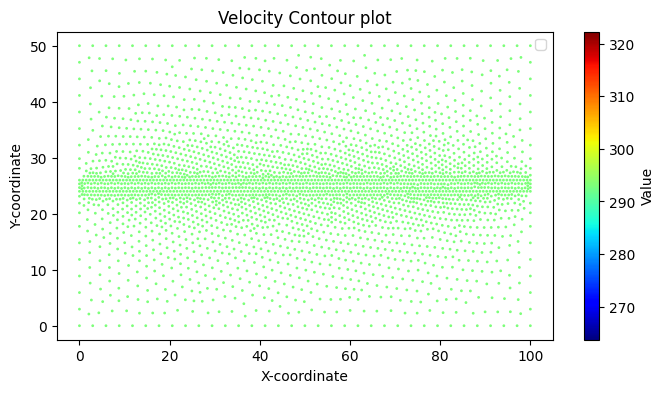

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


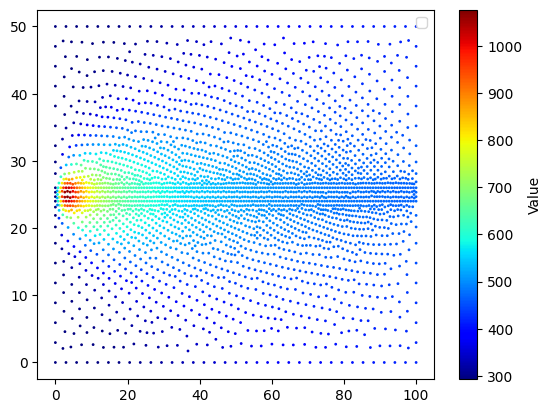

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


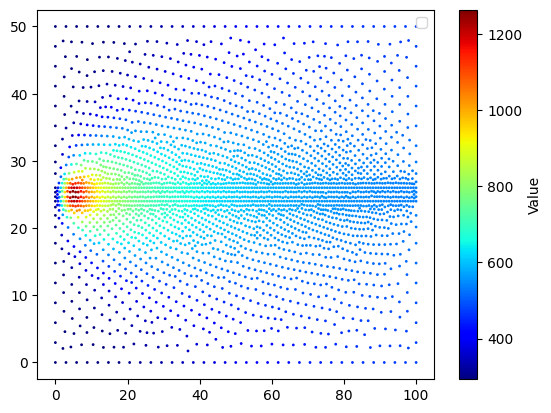

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


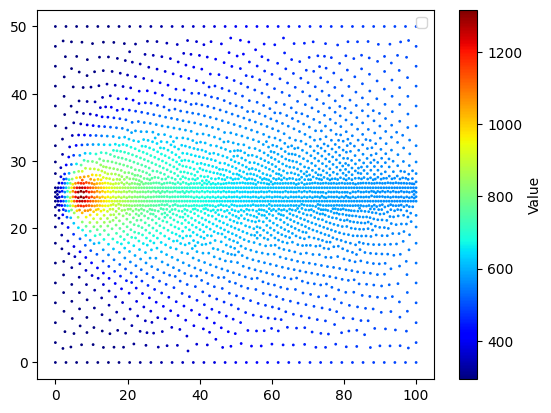

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


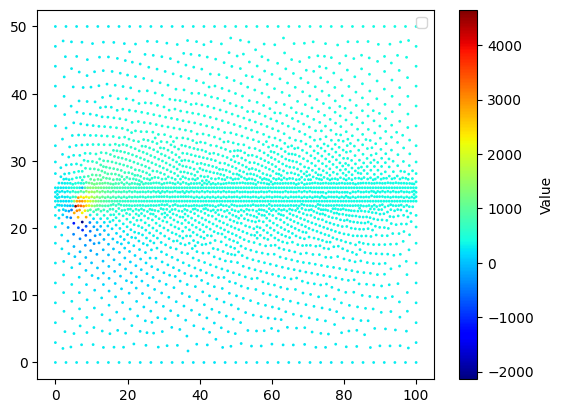

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


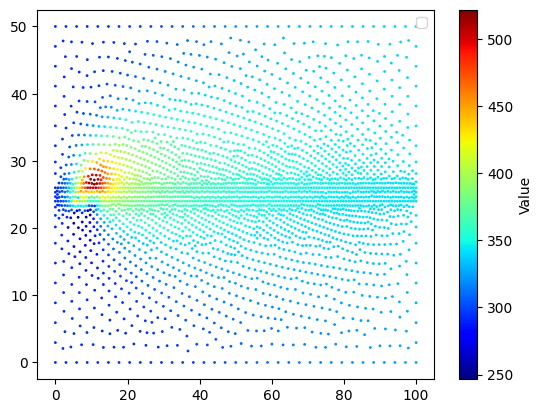

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


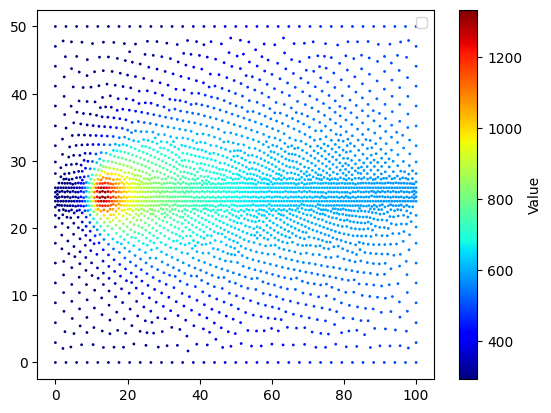

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


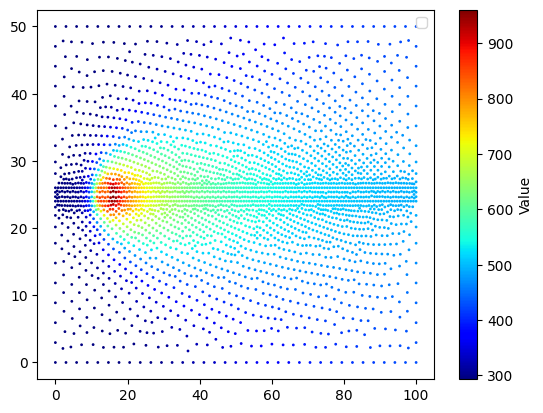

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


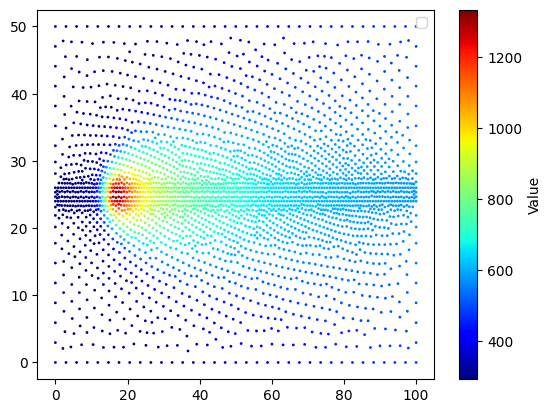

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


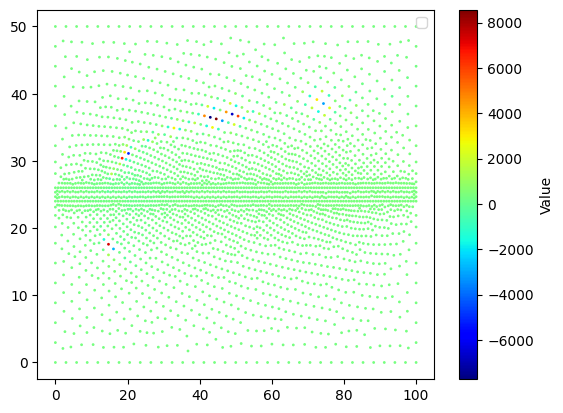

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


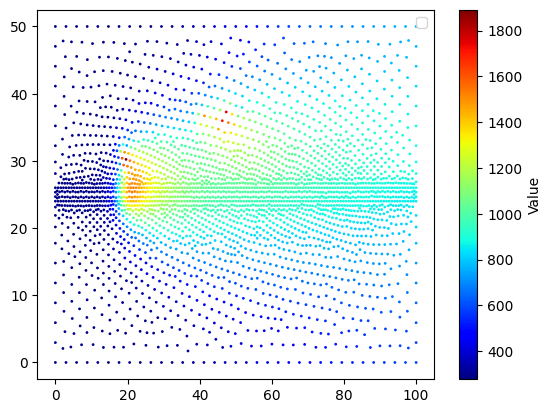

In [30]:
print(np.max(T))
plt.figure(figsize=(8,4))
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Velocity Contour plot')
for timestep in range(T.shape[0]):
    scatter = plt.scatter(mesh.coords[:, 0], mesh.coords[:, 1], c=T[timestep,:], cmap='jet', s=1, edgecolor=None)
    plt.legend()
    plt.colorbar(scatter, label='Value')
    plt.show()

8569.334598221532


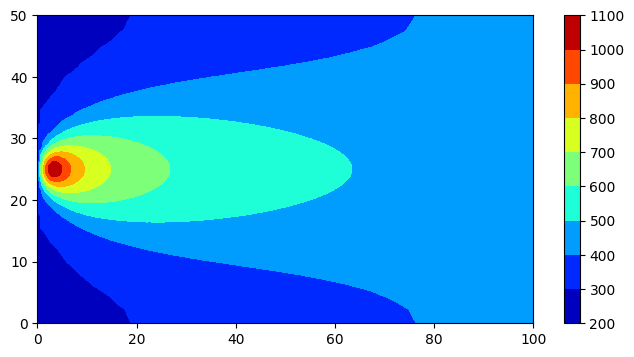

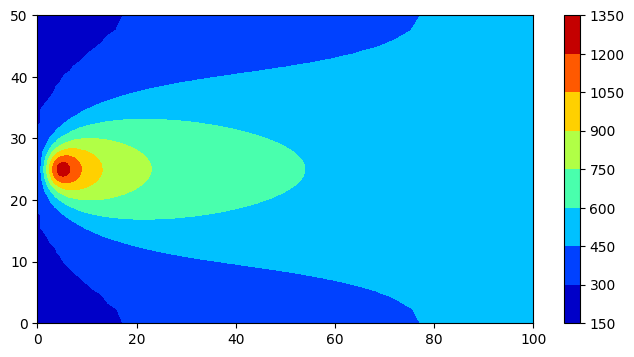

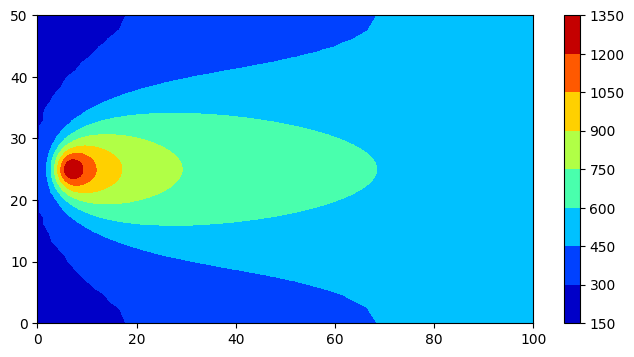

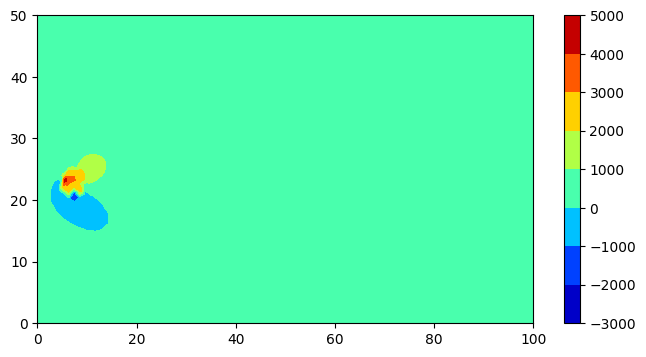

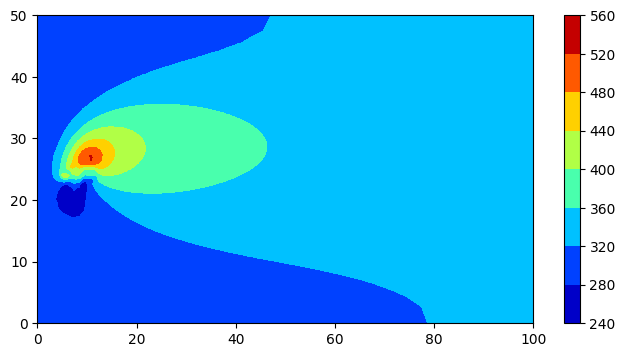

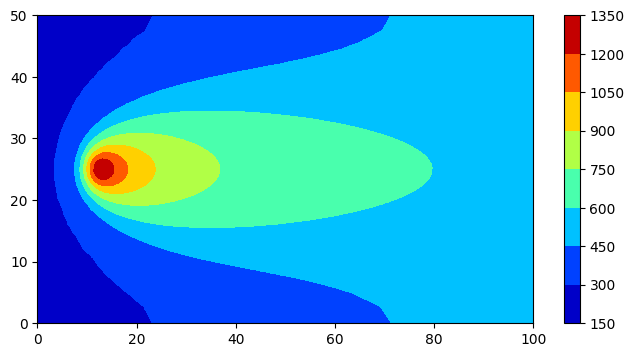

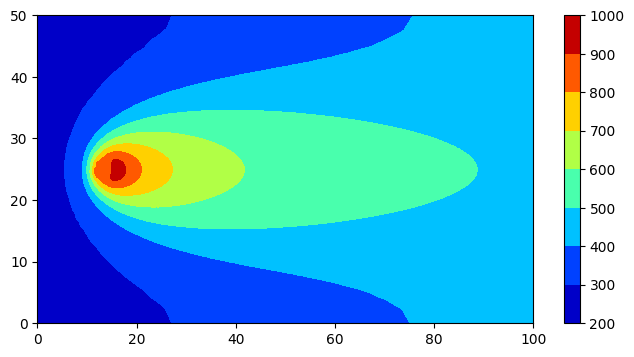

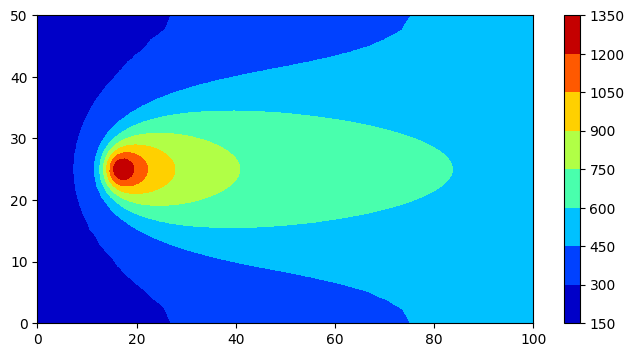

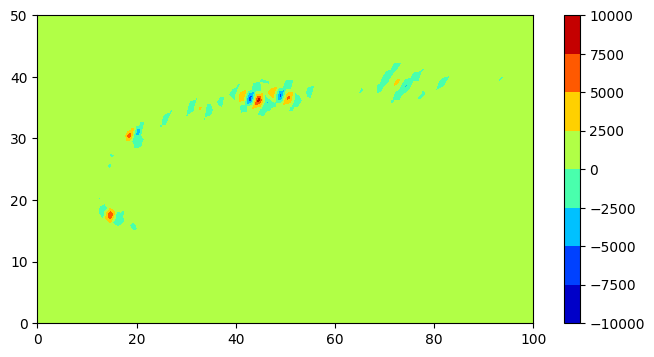

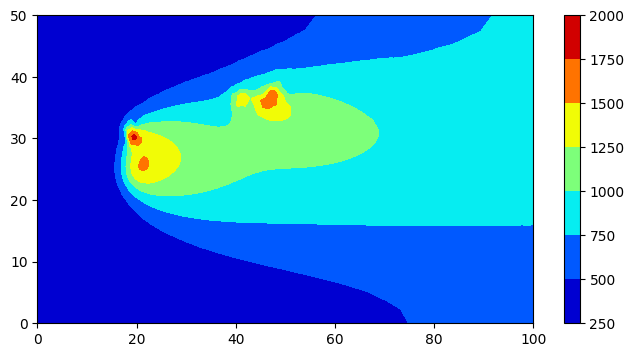

In [31]:
print(np.max(T))
for timestep in range(1,T.shape[0]):
    plt.figure(figsize=(8,4))
    plt.tricontourf(mesh.coords[:, 0], mesh.coords[:, 1],T[timestep,:],cmap='jet')
    plt.colorbar()
    plt.show()

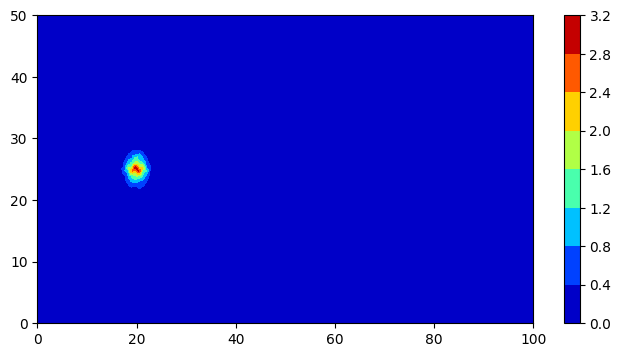

In [32]:
plt.figure(figsize=(8,4))
plt.tricontourf(mesh.coords[:, 0], mesh.coords[:, 1],mesh.S.reshape(-1),cmap='jet')
plt.colorbar()
plt.show()

In [33]:
n = 0
for ele in mesh.triNodesTags:
    n += 1 if np.min(mesh.coords[ele-1,1]) >=24 and np.min(mesh.coords[ele-1,1]) <= 26 else 0
print('Value of H is '+str((100*2/n)**.5)+' in mm')

Value of H is 0.4277646743846646 in mm


In [34]:
T.shape

(11, 2913)

In [35]:
np.where(mesh.coords[:,1]>=24*mesh.coords[:,1]<=26)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
len(mesh.triNodesTags)

28910

## Don't loook at the below code it's not updated with latest implementation

In [ ]:
dn = np.array([1,2,3]).reshape(-1,1)
(dn.T@dn)[0][0]

In [ ]:
mesh = RectangularMesh(mesh_factor=2,geo_file='rectangle.geo')

In [ ]:
A,K,S,Boundary = mesh.A,mesh.K,mesh.S,mesh.Boundary
coords = mesh.coords
dirichiletBoundary = np.where(coords[:,0] == 0)[0]
n = S.shape[0]
nodes = np.arange(n)
dirichiletBoundaryTemperature = 20
Temperature = np.ones((n,1))*dirichiletBoundaryTemperature
interiorNodes = np.delete(nodes,dirichiletBoundary)

In [ ]:
((S + Boundary - ((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))[interiorNodes])

In [ ]:
F = (A+K)[np.ix_(interiorNodes,interiorNodes)]
Temperature[interiorNodes] = np.linalg.pinv(F)@((S + Boundary - ((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))[interiorNodes])

In [ ]:
np.sum(((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Velocity Contour plot')
scatter = plt.scatter(mesh.coords[:, 0], mesh.coords[:, 1], c=Temperature, cmap='jet', s=7, edgecolor=None)
plt.legend()
plt.colorbar(scatter, label='Value')
plt.show()

In [ ]:
np.max(Temperature)

In [ ]:
nodesForAnalysis = np.where(abs(coords[:,1]-20) <= .5)[0]
plt.title('Velcity v/s X-coordinate')
plt.xlabel('X-coordinate')
plt.ylabel('Velocity')
plt.scatter(coords[nodesForAnalysis, 0], Temperature[nodesForAnalysis],s=3)
plt.legend()
plt.show()